# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./pics/ConceptGraph1.png',  width=1000, unconfined=False))

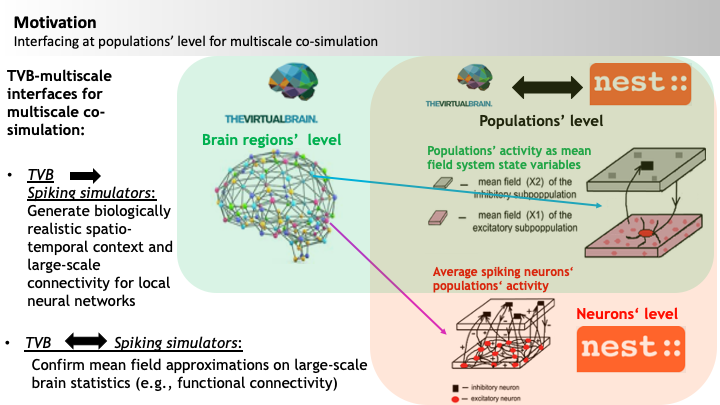

In [2]:
display(Image(filename='./pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

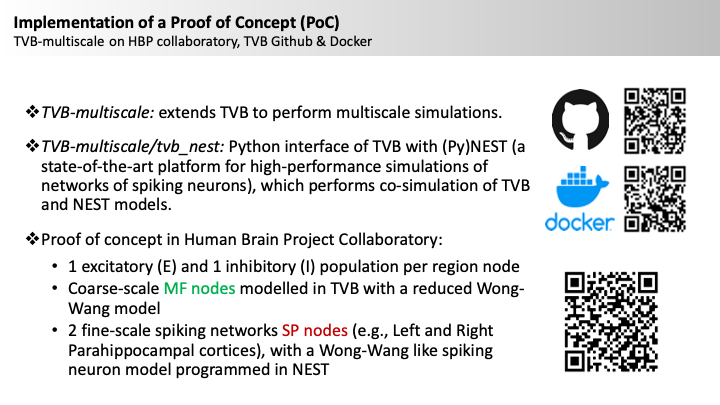

In [3]:
display(Image(filename='./pics/Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Reduced Wong-Wang TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + (1-{S_{n\prime}}(t))\gamma {R_{n\prime}}(t)$

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:

Membrane 

potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C - g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e$

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

Finally, $ {R_{int_{n}}}(t) $ overwrites the variable ${R_{n}}(t)$ via a user defined transform function:

${R_{n}}(t) = f_{NEST->TVB}({R_{int_{n}}}(t)) $

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

# WORKFLOW:

In [4]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale/docs/documented_example_notebook"
config = Config(output_base=os.path.join(home_path, "outputs_Izhikevich"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

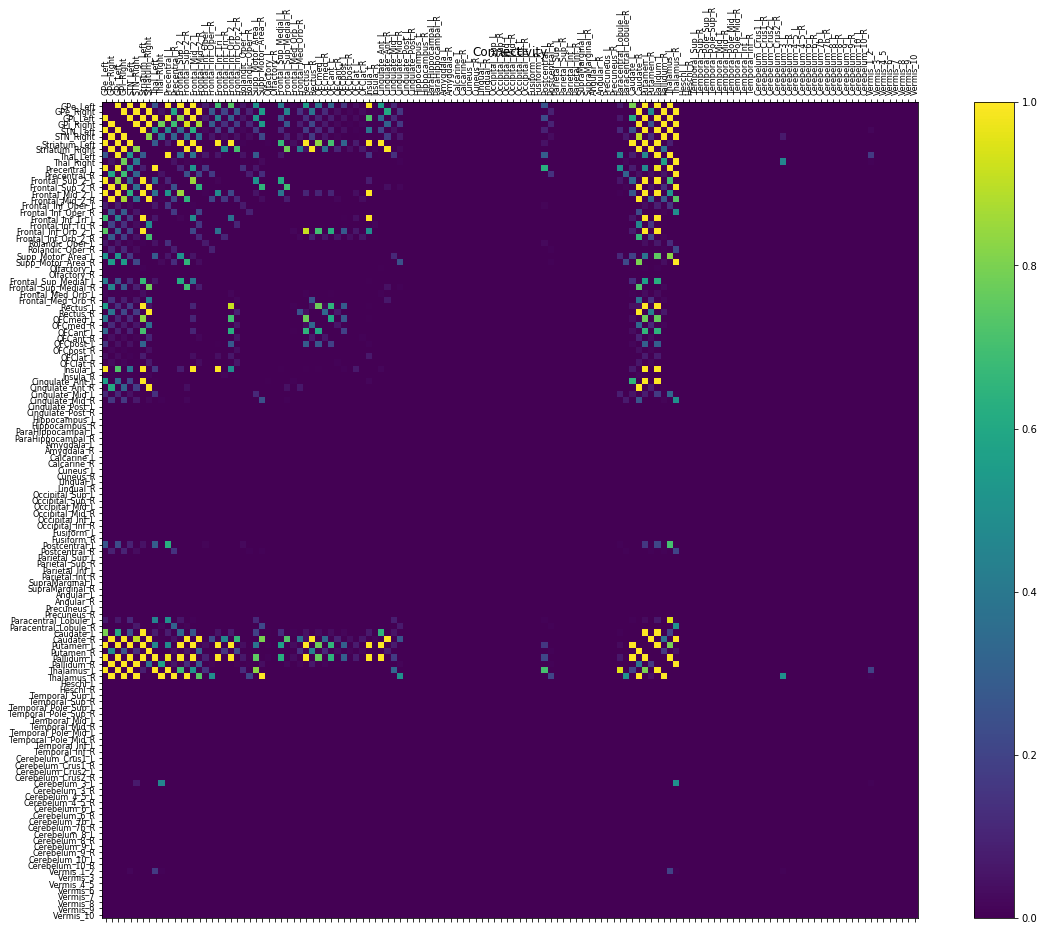

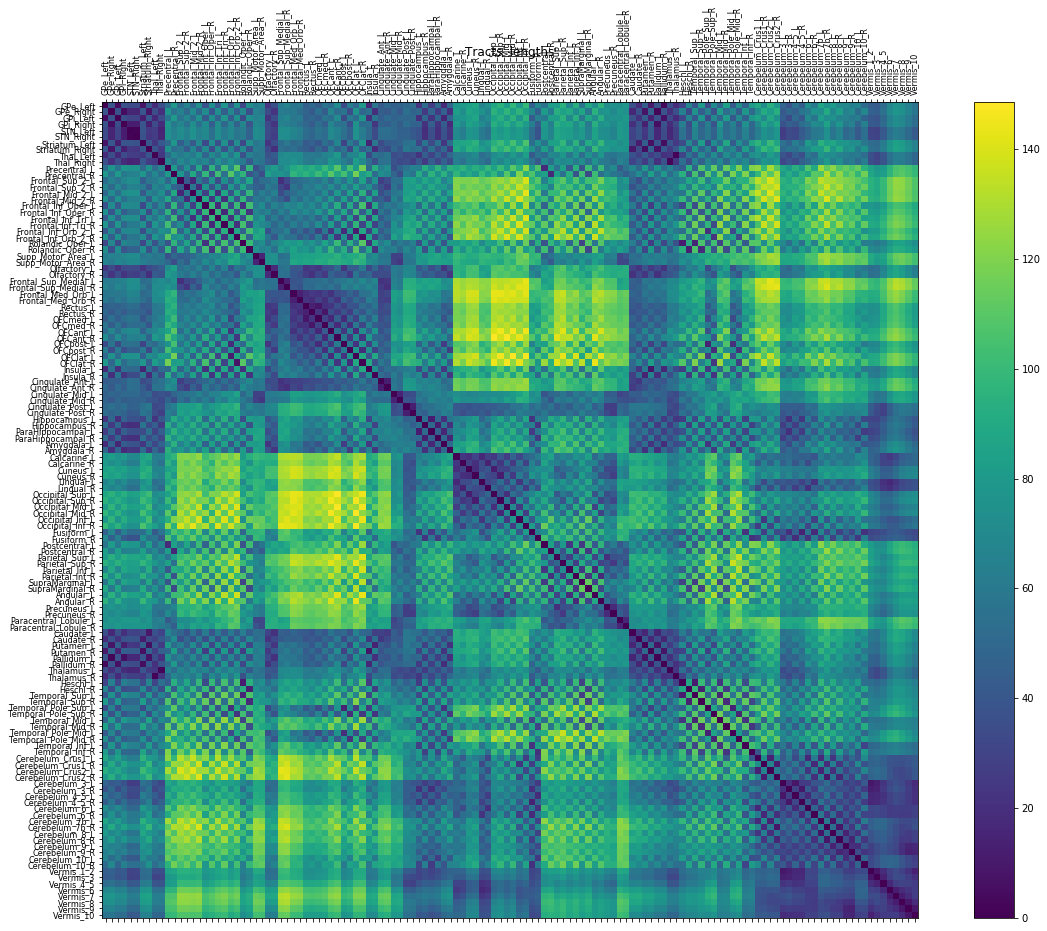

In [5]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# Load connectivity
#connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
w=np.loadtxt("./basal_ganglia_conn/conn_denis_weights.txt")
c=np.loadtxt("./basal_ganglia_conn/aal_plus_BG_centers.txt",usecols=range(1,3))
rl= np.loadtxt("./basal_ganglia_conn/aal_plus_BG_centers.txt",dtype="str", usecols=(0,))
t= np.loadtxt("./basal_ganglia_conn/BGplusAAL_tract_lengths.txt")

# Remove BG -> Cortex connections
w[[0, 1, 2, 3, 6, 7], :][:, 10:] = 0.0

connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.configure()
connectivity.speed = np.array([4.0])

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [6]:
# !!! Temporary hack in order to compile external modules !!!
if not os.path.isdir(os.path.join(os.environ["NEST_INSTALL_DIR"], "spatial")):
    !cp -r /home/docker/packages/nest-simulator/nestkernel/spatial /home/docker/env/neurosci/nest_build/include/nest
    ! mkdir -p /home/docker/packages/nest_modules_builds/iaf_cond_ww_deco;

In [7]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # the indices of fine scale regions modeled with NEST

from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config)



# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200 # for speed, normally 200

nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item() 

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0,
                                     "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                     "V_th": 40.0, "C_m": 50.0})

nest_model_builder.Igpe_nodes_ids = [0, 1]
nest_model_builder.Igpi_nodes_ids = [2, 3]
nest_model_builder.Estn_nodes_ids = [4, 5]
nest_model_builder.Eth_nodes_ids = [8, 9]
nest_model_builder.Istr_nodes_ids = [6, 7]
I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids

nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [4, 5], Eth in [8, 9]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0, 1], Igpi in [2, 3]
     "scale": 1.0},
    {"label": "I1", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # Isd1 in [6, 7]
     "scale": 1.0},
    {"label": "I2", "model": population_neuron_model,   # Isd2 in [6, 7]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0},
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, 'allow_multapses': True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}


within_node_delay = nest_model_builder.nest_instance.GetKernelStatus("min_delay")

nest_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe" and "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": -1.0, "delay": within_node_delay,
     "receptor_type": 0, "nodes": I_nodes_ids},  # None means apply to all
    {"source": "I1", "target": "I1",  # Isd1 -> Isd1 This is a self-connection for population "Isd1"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": -1.0, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "I2", "target": "I2",  # Isd2 -> Isd2 This is a self-connection for population "Isd2"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": -1.0, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    ]
    


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item()
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
nest_model_builder.global_coupling_scaling *= nest_model_builder.tvb_simulator.model.G[0].item()
        
class TVBWeightFun(object):
    tvb_weights = np.array([])
    global_coupling_scaling = 1.0
    sign = 1

    def __init__(self, tvb_weights, global_coupling_scaling=1.0, sign=1):
        self.tvb_weights = tvb_weights
        self.global_coupling_scaling = global_coupling_scaling
        self.sign = sign

    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.sign*self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "I1", "target": "I",             # "Isd1" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I2", "target": "I",            # "Isd2" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, -1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": ["I1", "I2"],   # "Eth" -> ["Isd1", "Isd2"]
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe", "Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(nest_model_builder.tvb_weights, 
                            nest_model_builder.global_coupling_scaling, 1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, "source_nodes": nest_model_builder.Estn_nodes_ids, "target_nodes": I_nodes_ids},  # None means apply to all
    ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_detector", "params": {"record_to": "memory"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "memory",
          'record_from': ["V_m", "U_m", "I_syn", "I_syn_ex", "I_syn_in", "g_L", "g_AMPA", "g_GABA_A"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

# Create a spike stimulus input device
nest_model_builder.input_devices = [
    {"model": "poisson_generator",
     "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
     "connections": {"BaselineEstn": ["E"]},  # "Estn"
     "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
     "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
    {"model": "poisson_generator",
     "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
     "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
     "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
     "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
    {"model": "poisson_generator",
     "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
     "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
     "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
     "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1},
    {"model": "ac_generator",
     "params": {"frequency": 30.0, "phase": 0.0, "amplitude": 1.0, "offset": 0.0,
                "start": 1.0},  # "stop": 100.0  "origin": 0.0, 
     "connections": {"DBS_Estn": ["E"]}, # "Estn"
     "nodes": nest_model_builder.Estn_nodes_ids,      # "Estn"
     "weights": 1.0, "delays": 0.0}
    ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()

populations_sizes = []
print("Population sizes: ")
for pop in nest_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))


2020-10-02 15:02:29,076 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-10-02 15:02:29,076 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-10-02 15:02:29,088 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-10-02 15:02:29,088 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-10-02 15:02:29,092 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-10-02 15:02:29,092 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-10-02 15:02:29,095 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-10-02 15:02:29,095 - INFO - tvb_multiscale.t

2020-10-02 15:02:29,321 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-10-02 15:02:29,321 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-10-02 15:02:29,333 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - FAILED! We need to first compile it!
2020-10-02 15:02:29,333 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - FAILED! We need to first compile it!
2020-10-02 15:02:29,812 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-10-02 15:02:29,812 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-10-02 15:02:29,822 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Compiling izhikevich_hamker...
2020-10-02 15:02:29,822 - INFO

NESTErrors.DynamicModuleManagementError: ("DynamicModuleManagementError in Install: Module 'izhikevich_hamkermodule' could not be opened.\nThe dynamic loader returned the following error: 'file not found'.\n\nPlease check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!", 'DynamicModuleManagementError', 'Install', ": Module 'izhikevich_hamkermodule' could not be opened.\nThe dynamic loader returned the following error: 'file not found'.\n\nPlease check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!")

In [ ]:
print(nest_network.print_str(connectivity=True))

## 3. Build the TVB-NEST interface

In [ ]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = None  # "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------


# # TVB -> NEST


# # --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

# tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
# tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
    
# tvb_weight_fun = \
#     lambda source_node, target_node: \
#                  scale_tvb_weight(source_node, target_node, 
#                                   tvb_nest_builder.tvb_weights, scale=tvb_nest_builder.global_coupling_scaling)

# tvb_delay_fun = \
#     lambda source_node, target_node: \
#         np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

# tvb_nest_builder.tvb_to_spikeNet_interfaces = []
# if tvb_to_nest_mode == "rate":
#     # Mean spike rates are applied in parallel to all target neurons

#     for pop in nest_model_builder.populations:
#         tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
#             {"model": "inhomogeneous_poisson_generator",
#              "params": {"allow_offgrid_times": False},
#         # # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
#              "interface_weights": 1.0, 
#         # Applied outside NEST for each interface device
#         # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#             "weights": lambda tvb_node_id, nest_node_id: tvb_weight_fun(tvb_node_id, nest_node_id),
#             "delays": lambda tvb_node_id, nest_node_id: tvb_delay_fun(tvb_node_id, nest_node_id),
#             "receptor_type": 0,
#             # --------------------------------------------------------------------------------------------------------------
#             #             TVB sv -> NEST population
#             "connections": {"R": pop["label"]},
#             "source_nodes": None, "target_nodes": pop["nodes"]})  # None means all here

    
# if nest_to_tvb:
#     tvb_nest_builder.spikeNet_to_tvb_interfaces = []
#     # TVB <-- NEST:
#     # Use S_e and S_i instead of r_e and r_i
#     # for transmitting to the TVB state variables directly
#     connections = OrderedDict()
#     for src_pop, nodes in zip(["I",         "E"],
#                               [[0, 1, 2, 3], [4, 5, 8, 9]]):
#         #            TVB <- NEST
#         connections["Rin"] = src_pop
#         tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
#             {"model": "spike_recorder", "params": {},
#         # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#              "interface_weights": 1.0, "delays": 0.0,
#         # -----------------------------------------------------------------------------------------------------------------
#              "connections": connections, "nodes": nodes})  # None means all here
#     #            TVB <- NEST
#     connections["Rin"] = ["I1", "I2"]
#     tvb_nest_builder.nest_to_tvb_interfaces.append(
#             {"model": "spike_recorder", "params": {},
#         # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#              "weights": 1.0, "delays": 0.0,
#         # -----------------------------------------------------------------------------------------------------------------
#              "connections": connections, "nodes": [6, 7]})  # None means all
    
# tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# # We return from a NEST spike_recorder the ratio number_of_population_spikes / number_of_population_neurons
# # for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# # as long as a neuron cannot fire twice during a TVB time step, i.e.,
# # as long as the TVB time step (usually 0.001 to 0.1 ms)
# # is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
# tvb_nest_builder.w_spikes_to_tvb = 1000.0

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

In [ ]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))

## 4. Configure simulator, simulate, gather results

In [ ]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length=110.0
transient = 10.0 # simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

In [ ]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [ ]:
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables",
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, plotter=plotter, config=config)

In [ ]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

# Remove transient, if any
if transient:
    source_ts = source_ts[transient:]
    exclude_times = [0.0, transient]
else:
    exclude_times = []
t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

In [ ]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

In [ ]:
# TVB time series raster plot:
if source_ts.number_of_labels > 9:
    source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

In [ ]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                               figname="Spiking nodes TVB Time Series");

In [ ]:
# Focus on the nodes modelled in NEST: raster plot
source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                           figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [ ]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Plot population mean membrane potential time series

In [ ]:
%matplotlib inline 
# Plot NEST multimeter variables
# Get continuous state variables from NEST via interfaces to NEST multimeter devices
# Get them directly as mean field quantities..
multimeter_mean_data = \
    simulator.tvb_spikeNet_interface.get_mean_data_from_multimeter_to_TimeSeries(connectivity=simulator.connectivity)
if transient:
    multimeter_mean_data = multimeter_mean_data[transient:]
if multimeter_mean_data is not None and multimeter_mean_data.size > 0:
     plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                        time_series_class=TimeSeriesXarray, time_series_args={},
                                        var_pop_join_str=" - ", default_population_label="population",
                                        figname="NEST region time series");
if n_spiking_nodes > 3:
    plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                   time_series_class=TimeSeriesXarray, time_series_args={},
                                   var_pop_join_str=" - ", default_population_label="population",
                                   figname="NEST region time series raster");


### Plot spikes' raster and mean spike rate for NEST regions

In [ ]:
# # Plot spikes and mean field spike rates time series
# mf_rates_ts, spike_detectors = \
#         simulator.tvb_spikeNet_interface.get_mean_spikes_rates_to_TimeSeries(
#             spikes_kernel_width=1.0,  # ms
#             spikes_kernel_overlap=0.5, time=t, connectivity=simulator.connectivity)
# if spike_detectors is not None and mf_rates_ts.size > 0:
#     plotter.plot_spike_detectors(spike_detectors, rates=mf_rates_ts, title='Population spikes and mean spike rate');

### Get per neuron NEST time series and plot them, as well as mean quantities

In [ ]:
from xarray import DataArray
from tvb.contrib.scripts.utils.data_structures_utils import concatenate_heterogeneous_DataArrays

spiking_network = simulator.tvb_spikeNet_interface.spiking_network

# Time Series
nest_ts = spiking_network.get_data_from_multimeter(mode="per_neuron")
if not isinstance(nest_ts, DataArray):
    # assuming a pandas Series due to heterogeneity of populations in among brain regions:
    nest_ts = concatenate_heterogeneous_DataArrays(nest_ts, "Population",
                                                   transpose_dims=["Time", "Variable", 
                                                                   "Region", "Population", "Neuron"])
nest_ts = TimeSeriesXarray(nest_ts, connectivity=simulator.connectivity)
if transient:
    nest_ts = nest_ts[transient:]
if n_spiking_nodes <= 3:
    nest_ts.plot_map(y=nest_ts._data.dims[4], row=nest_ts._data.dims[2], col=nest_ts._data.dims[3],
                     per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);

In [ ]:
# Plot per neuron time series
nest_ts.plot_map(y=nest_ts._data.dims[4], row=nest_ts._data.dims[2], col=nest_ts._data.dims[3],
                 per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);

In [ ]:
# Compute mean field
ts = TimeSeriesXarray(nest_ts._data.mean(axis=-1), connectivity=nest_ts.connectivity,
                      title="Mean field spiking nodes time series")
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(ts._data, connectivity=ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, ts.title)+".h5", recursive=False)

In [ ]:
# Plot mean field
ts.plot_timeseries(plotter_config=plotter.config, per_variable=True)
if n_spiking_nodes > 3:
    ts.plot_raster(plotter_config=plotter.config, per_variable=True, linestyle="--", alpha=0.5, linewidth=0.5);

In [ ]:
from xarray import DataArray, concat

# Spikes
nest_spikes = spiking_network.get_spikes(mode="events", return_type="Series", exclude_times=exclude_times)
if writer:
    writer.write_object(nest_spikes.to_dict(), path=os.path.join(config.out.FOLDER_RES,  "NEST_Spikes") + ".h5")

# Compute mean spike rates
spike_rates = []
duration = (t[-1] - t[0]) / 1000  # in sec
for i_pop, (pop_label, pop_spikes) in enumerate(nest_spikes.iteritems()):
    spike_rates.append([])
    reg_labels = []
    for reg_label, reg_spikes in pop_spikes.iteritems():
        reg_labels.append(reg_label)
        # rates (spikes/sec) =
        #   total_number_of_spikes (int) / total_time_duration (sec) / total_number_of_neurons_in_pop (int)
        spike_rates[-1].append(len(reg_spikes["times"]) / duration / populations_sizes[i_pop])
    spike_rates[-1] = np.array(spike_rates[-1])
    while spike_rates[-1].ndim < 2:
        spike_rates[-1] = spike_rates[-1][np.newaxis]
    spike_rates[-1] = DataArray(np.array(spike_rates[-1]), 
                                dims=["Population", "Region"], name="NEST_spike_rates",
                                coords={"Population": [pop_label], "Region": reg_labels})
spike_rates = concat(spike_rates, spike_rates[-1].dims[0], fill_value=np.nan)
print(spike_rates)
if writer:
    writer.write_object(spike_rates.to_dict(), path=os.path.join(config.out.FOLDER_RES, spike_rates.name) + ".h5")

In [ ]:
# Plot spikes
plotter.plot_spike_events(nest_spikes, figsize=FIGSIZE);

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>